**Рекомендательные системы**

test.csv - набор данных, для которого вы должны сделать предсказания. У каждого наобора userid, itemid есть свой id, для которого вы должны сделать предсказание.

overall - рейтинг, который поставил пользователь

verified - был ли отзыв верифицирован

reviewTime - когда был отзыв написан

reviewerName - имя пользователя

reviewText - текст отзыва

summary - сжатый отзыв

vote - количество голосований за отзыв

style - метаданные

image - изображение продукта

userid - id пользователя

itemid - id товара

id - id для предсказания


In [1]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.sparse as sparse
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
import nmslib
import pickle

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json


In [3]:
#подгрузим датасеты
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# откроем json с метаданными и создадим датасет "meta"
with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as x:
    list_meta = []
    for i in x.readlines():
        list_meta.append(json.loads(i))
        
meta = pd.DataFrame(list_meta)

# Удалим дубликаты из тренировочного датасета
train.drop_duplicates(inplace = True)

In [5]:
# Объединим train и meta по идентификатору asin (Amazon Standard Identification Number)
data = pd.merge(train, meta, on='asin')

In [6]:
#посмотрим на датасеты

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 89.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Dat

Видим, что в тренировочном датасете на три столбца больше:

overall - оценка по пятибальной шкале

reviewText - текст отзыва

summary - краткое содержание отзыва

rating - целевая переменная

отсутствует Id

**Разведывательный анализ данных (EDA)**

In [7]:
#посмотрим на данные
data.head()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,...,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5.0,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,3.0,True,"03 11, 2017",B01CPNIEQG,Ella,"Ummm....interesting spice blend, but not reall...","It's not a bad taste, but they really shouldn'...",1489190400,4,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
3,5.0,False,"05 18, 2016",B01CPNIEQG,A. Yeager,I have loved adobo seasoning for years. Once I...,I have loved adobo seasoning for years,1463529600,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
4,5.0,False,"05 18, 2016",B01CPNIEQG,LuvstoShop,I love this blend. It makes my hashbrowns! So ...,Five Stars,1463529600,NaN,NaN,...,Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

У нас 30 признаков. 24 из них категориальные,  5 числовых и 1 бинарный, и Рассмотрим каждый из них по отдельности

Напишем функцию для удобного анализа

In [9]:
# с гистограммой
def col_info(i):
    print('Количество пропусков: {},'.format(i.isnull().sum()))
    print('{},'.format(i.describe()))
    print('Распределение:\n{},'.format(i.value_counts()))
    i.hist()

# без гистограмы
def col_info_2(i):
    print('Количество пропусков: {},'.format(i.isnull().sum()))
    print('{},'.format(i.describe()))
    print('Распределение:\n{},'.format(i.value_counts()))

**Overall**

Количество пропусков: 0,
count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,
Распределение:
5.0    607524
4.0    111868
3.0     59795
1.0     37071
2.0     31335
Name: overall, dtype: int64,


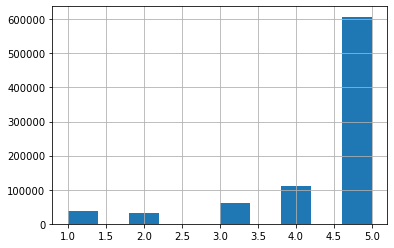

In [10]:
col_info(data.overall)

Рейтинг по пятибальной шкале. в основном оценка "пять". Данного признака нет test, но он пригодится для анализа других признаков. 

Преобразуем в формат int32

In [11]:
data['overall']=data['overall'].astype('int32')

**verified**

In [12]:
col_info_2(data.verified)

Количество пропусков: 0,
count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object,
Распределение:
True     736369
False    111224
Name: verified, dtype: int64,


Признак означает, верификацию аккаунта пользователя. Пропусков нет. Заменим значения на 1 и 0.

In [13]:
dictionary = {True: 1, False: 0}
data['verified'] = data['verified'].map(dictionary)

**reviewTime**

In [14]:
col_info_2(data.reviewTime)

Количество пропусков: 0,
count         847593
unique          4580
top       03 1, 2016
freq             941
Name: reviewTime, dtype: object,
Распределение:
03 1, 2016     941
07 14, 2016    873
01 20, 2016    783
06 3, 2015     783
02 20, 2016    767
              ... 
01 5, 2008       1
05 27, 2007      1
01 13, 2006      1
12 6, 2005       1
08 11, 2006      1
Name: reviewTime, Length: 4580, dtype: int64,


Дата когда был оставлен отзыв. Задвой информации с unixReviewTime. Удалим  столбец.

In [15]:
data = data.drop(['reviewTime'], axis=1)

**reviewerName**

In [16]:
col_info_2(data.reviewerName)

Количество пропусков: 168,
count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object,
Распределение:
Amazon Customer    31346
Kindle Customer     6128
Linda                729
John                 714
David                606
                   ...  
Lipoa Peltier          1
DisneylandToday        1
June Crawford          1
Rodney Roberts         1
jgh                    1
Name: reviewerName, Length: 101207, dtype: int64,


Видно, что много отзывов с Amazon и Kindle. Есть пропуски. Проведем проверку,  userid у Amazon Customer и Kindle Custome, вдруг одному имени пользователя  соответствует несколько userid

In [17]:
data[data.reviewerName=='Amazon Customer'].userid.value_counts()

7477      91
1330      60
24035     55
8027      53
15752     44
          ..
73871      1
115807     1
58045      1
62767      1
65437      1
Name: userid, Length: 5329, dtype: int64

In [18]:
data[data.reviewerName=='Kindle Customer'].userid.value_counts()

6904      69
13352     55
1569      55
30339     44
44734     42
          ..
107170     1
106847     1
45631      1
125914     1
223        1
Name: userid, Length: 1003, dtype: int64

Так и есть, удалим столбец

In [19]:
data = data.drop(['reviewerName'], axis=1)

**reviewText**

Псомотрим есть ли пропуски

In [20]:
data.reviewText.isnull().sum()

278

Думаю, что из текста отзыва мы не сможем выделить что-то полезное плюс данного признака нет в test, поэтому удалим столбец

In [21]:
data = data.drop(['reviewText'], axis=1)

**summary**

Посмотрим есть ли пропуски

In [22]:
data.summary.isnull().sum()

167

Думаю, что из текста отзыва мы не сможем выделить что-то полезное плюс данного признака нет в test, поэтому удалим столбец

In [23]:
data = data.drop(['summary'], axis=1)

**asin**

In [24]:
col_info_2(data.asin)

Количество пропусков: 0,
count         847593
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object,
Распределение:
B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B0001LO3FG    4252
B00R7PWK7W    2449
              ... 
B01965DYGQ       1
B00BMUCNMU       1
B000VH6TJS       1
B000WS1S0G       1
B0041FWEL8       1
Name: asin, Length: 41302, dtype: int64,


В датасете 41302 различных товара. Признак использоваться не будет, поэтому удалим его.

In [25]:
data = data.drop(['asin'], axis=1)

**unixReviewTime**

In [26]:
col_info_2(data.unixReviewTime)

Количество пропусков: 0,
count    8.475930e+05
mean     1.441914e+09
std      5.992384e+07
min      9.657792e+08
25%      1.412122e+09
50%      1.449360e+09
75%      1.485130e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,
Распределение:
1456790400    941
1468454400    873
1433289600    783
1453248000    783
1455926400    767
             ... 
1113782400      1
1132444800      1
1167609600      1
1105142400      1
1155081600      1
Name: unixReviewTime, Length: 4580, dtype: int64,


Пропусков нет. Посмотрим, как изменялись оценки со временем.

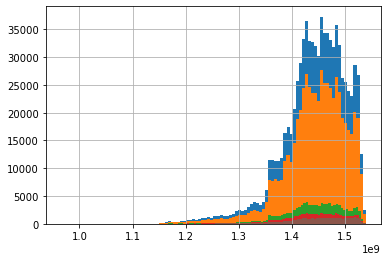

In [27]:
data.unixReviewTime.hist(bins=100)
data[data.overall == 5].unixReviewTime.hist(bins=100)
data[data.overall == 4].unixReviewTime.hist(bins=100)
data[data.overall == 3].unixReviewTime.hist(bins=100)
data[data.overall == 2].unixReviewTime.hist(bins=100)
data[data.overall == 1].unixReviewTime.hist(bins=100)

Используем этот признак для создания новых фич. Определим категориальные рамки и позже созадим на их основании dummy переменные 

In [28]:
date_min = data.unixReviewTime.min()
date_25 = int(data.unixReviewTime.quantile(0.25))
date_50 = int(data.unixReviewTime.quantile(0.50))
date_75 = int(data.unixReviewTime.quantile(0.75))
date_max = data.unixReviewTime.max()

In [29]:
def date_category(i):
    if i <= date_25: i = 'old'
    elif date_25 < i <= date_50: i = 'mid_old'
    elif date_50 < i <= date_75: i = 'mid_new'
    elif date_75 < i: i = 'new'
    return i      

# Заменим значения в столбце на категории
data['unixReviewTime'] = data['unixReviewTime'].apply(lambda i: date_category(i))

**vote**

In [30]:
col_info_2(data.vote)

Количество пропусков: 728732,
count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64,
Распределение:
2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
145          1
316.0        1
317.0        1
327.0        1
416          1
Name: vote, Length: 477, dtype: int64,


Посмотрим на данные

In [31]:
data.vote.unique()

array([nan, 4.0, 5.0, 8.0, '7', 7.0, 3.0, 2.0, '28', '2', '4', 6.0, '3',
       '30', '14', '8', '6', '17', '5', '142', '21', '16', 9.0, 15.0,
       12.0, 18.0, 404.0, 22.0, 10.0, '22', 13.0, 136.0, '18', '12', '34',
       '69', '10', '48', '20', 11.0, 14.0, 133.0, 16.0, 36.0, 31.0, 117.0,
       17.0, 29.0, 37.0, '39', '9', '11', '27', 172.0, 251.0, '41', 52.0,
       38.0, 27.0, '15', '61', '38', 25.0, 127.0, '36', 28.0, 61.0, 24.0,
       49.0, 51.0, 19.0, 20.0, '13', 74.0, 121.0, 45.0, 33.0, 266.0, '44',
       '232', '25', 47.0, 138.0, 176.0, 75.0, 30.0, '42', 128.0, '24',
       '184', '624', 40.0, 272.0, 881.0, 53.0, 21.0, 43.0, 184.0, '35',
       35.0, 23.0, 39.0, 227.0, 42.0, 507.0, 59.0, 114.0, 87.0, 55.0,
       26.0, '19', 41.0, '82', 143.0, 73.0, 187.0, 66.0, '45', 56.0, '76',
       112.0, 57.0, '115', '75', '33', '50', 50.0, 68.0, 54.0, 63.0, '47',
       '43', 108.0, 185.0, '302', 208.0, '59', 269.0, 78.0, 103.0, '26',
       148.0, 160.0, '80', 32.0, 71.0, 130.0, 85

данные разнообразные, с 0, без 0, есть пропуски. Заменим пропуски на 0

In [32]:
data.vote = data.vote.fillna(0)

Приведем в соответствие

In [33]:
data['vote'] = data['vote'].astype('str')
data['vote'] = data['vote'].apply(lambda x: x.replace(',', ''))

data['vote'] = data['vote'].apply(lambda x: x.replace('nan', '0'))
data.vote = data.vote.fillna(0)

data['vote'] = data['vote'].astype('float')
data['vote'] = data['vote'].astype('int32')

data.vote.unique()

array([   0,    4,    5,    8,    7,    3,    2,   28,    6,   30,   14,
         17,  142,   21,   16,    9,   15,   12,   18,  404,   22,   10,
         13,  136,   34,   69,   48,   20,   11,  133,   36,   31,  117,
         29,   37,   39,   27,  172,  251,   41,   52,   38,   61,   25,
        127,   24,   49,   51,   19,   74,  121,   45,   33,  266,   44,
        232,   47,  138,  176,   75,   42,  128,  184,  624,   40,  272,
        881,   53,   43,   35,   23,  227,  507,   59,  114,   87,   55,
         26,   82,  143,   73,  187,   66,   56,   76,  112,   57,  115,
         50,   68,   54,   63,  108,  185,  302,  208,  269,   78,  103,
        148,  160,   80,   32,   71,  130,   85,  123,   62,   95,  603,
         88,   86,  132,   67,  119,   70,  296,  560,   91,   46,  203,
        360,  857,  107,  679,  146,   89,   60,   94,   77,  129,  122,
        223,  100,   65,  101,   64,  255,  116,  171,  276,  186,  190,
        531,  166, 1157,  435,  516,  416,  173,   

Создадим 3 категории по количеству голосов и создадим на их основе dummy переменные

In [34]:
def vote_category(i):
    if i < 10: i = 'low'
    elif 10 <= i <= 100: i = 'middle'
    elif 100 < i: i = 'high'
    return i      

data['vote'] = data['vote'].apply(lambda i: vote_category(i))

**style**

In [35]:
col_info_2(data['style'])

Количество пропусков: 407242,
count                      440351
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4856
Name: style, dtype: object,
Распределение:
{'Size:': ' Pack of 1'}                                              4856
{'Package Quantity:': ' 1'}                                          4526
{'Package Type:': ' Standard Packaging'}                             3898
{'Size:': ' 1 Pack'}                                                 3848
{'Size:': ' 24 Count'}                                               3640
                                                                     ... 
{'Size:': ' 3 Count', 'Flavor:': ' Maple'}                              1
{'Size:': ' 16 Ounce (Pack of 12)', 'Flavor:': ' Thin Spaghetti'}       1
{'Size:': ' Pack of 20 - 2 oz', 'Flavor:': ' Original'}                 1
{'Size:': ' 5 Ounce', 'Flavor:': ' Fruit Medley, organic'}              1
{'Flavor:': ' Puttanesca'}                         

очень много пропусков, удалим столбец

In [36]:
data = data.drop(['style'], axis=1)

**image_x**

Удалим столбец

In [37]:
data = data.drop(['image_x'], axis=1)

**userid**

In [38]:
col_info_2(data.userid)

Количество пропусков: 0,
count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64,
Распределение:
842      427
17987    317
355      302
2024     296
2809     279
        ... 
66068      1
71046      1
90602      1
37414      1
77032      1
Name: userid, Length: 127448, dtype: int64,


id пользователя, пропусков нет

**itemid**

In [39]:
col_info_2(data.itemid)

Количество пропусков: 0,
count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64,
Распределение:
22208    5430
23540    4733
24556    4611
379      4252
32046    2449
         ... 
38965       1
23635       1
34272       1
39917       1
38902       1
Name: itemid, Length: 41302, dtype: int64,


id товара, пропусков нет

**rating**

In [40]:
col_info_2(data.rating)

Количество пропусков: 0,
count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64,
Распределение:
1.0    719392
0.0    128201
Name: rating, dtype: int64,


Целевая бинарная переменная. Варианта два, понравилось или нет.
Посмотрим на зависимость от оценки

In [41]:
data[data.rating == 0].overall.value_counts()

3    59795
1    37071
2    31335
Name: overall, dtype: int64

In [42]:
data[data.rating == 1].overall.value_counts()

5    607524
4    111868
Name: overall, dtype: int64

Получается, что при оценках 4 или 5 товар понравился. 1,2 или 3 - нет.

**category**

In [43]:
data.category.sample()

201485    [Grocery & Gourmet Food, Cooking & Baking, Nut...
Name: category, dtype: object

В данном столбце списки категорий к которым относится товар. Удалим его

In [44]:
data = data.drop(['category'], axis = 1)

**description**

In [45]:
data.description.sample()

323176    NaN
Name: description, dtype: object

В данном столбце описание товара. Удалим его

In [46]:
data = data.drop(['description'], axis = 1)

**title**

In [47]:
data.title.sample()

4266    Twinings of London English Afternoon Black Tea...
Name: title, dtype: object

Тоже самое, что и description. Удалим

In [48]:
data = data.drop(['title'], axis = 1)

**brand**

In [49]:
col_info_2(data.brand)

Количество пропусков: 6104,
count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object,
Распределение:
KIND                           22506
Bob's Red Mill                 13061
Twinings                       11182
Planters                       10384
Frontier                        6926
                               ...  
Peanut Butter Americano            1
Mayers                             1
Coco Lite Muligrn Pop Cakes        1
red dates                          1
Global Healing Center              1
Name: brand, Length: 8866, dtype: int64,


В данном столбце информация о производителе. Удалим его

In [50]:
data = data.drop(['brand'], axis = 1)

**rank**

In [51]:
data ['rank'].sample()

753581    53,235inGroceryGourmetFood(
Name: rank, dtype: object

Приведем значения признака к единому виду

In [52]:
data['rank'] = data['rank'].astype('str')
# Удалим все значения кроме числовых
data['rank'] = data['rank'].apply(lambda x: re.sub('\D', '', x))

In [53]:
data['rank'] = data['rank'].astype('str')
# Оставим числовые значения
data['rank'] = data['rank'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на высокий ранг
data['rank'] = data['rank'].apply(lambda x: 10000000 if x == '' else x)
data['rank'] = data['rank'].astype('float')
# Заменим большие значения на высокий ранг
data['rank'] = data['rank'].apply(lambda x: 10000000 if x > 10000000 else x)
data['rank'] = data['rank'].astype('int32')
# Результат
col_info_2(data['rank'])

Количество пропусков: 0,
count    8.475930e+05
mean     6.676661e+05
std      2.289291e+06
min      4.000000e+00
25%      1.094000e+04
50%      4.999900e+04
75%      1.799160e+05
max      1.000000e+07
Name: rank, dtype: float64,
Распределение:
10000000    47163
18           7421
4575         4733
2949         4611
142261       4252
            ...  
106875          1
42042           1
770318          1
178098          1
294806          1
Name: rank, Length: 35977, dtype: int64,


Заменим значения на категории для создания dummy переменных

In [54]:
def rank_category(i):
    if i < 1000: i = 'high'
    elif 1000 <= i <= 20000: i = 'middle'
    elif 20000 < i: i = 'low'
    return i      

data['rank'] = data['rank'].apply(lambda i: rank_category(i))

**also_view**

In [55]:
data.also_view.sample()

369399    [B01B22QE9K, B00872YZEA, B00LR5OJVS, B0002VXYQ...
Name: also_view, dtype: object

Данный столбец содержит информацию в виде списка товаров asin. Удалим его

In [56]:
data = data.drop(['also_view'], axis = 1)

**main_cat**

In [57]:
col_info_2(data.main_cat)

Количество пропусков: 955,
count      846638
unique         17
top       Grocery
freq       802613
Name: main_cat, dtype: object,
Распределение:
Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Software                          3
Musical Instruments               3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64,


Избавимся от пропусков путем замены на Other далее создадим dummy переменные

In [58]:
data.main_cat = data.main_cat.fillna('Other')

**price**

In [59]:
col_info_2(data.price)

Количество пропусков: 258621,
count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object,
Распределение:
$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$30.05                  2
$35.16                  1
$6.93                   1
$44.14                  1
$19.99 - $295.00        1
Name: price, Length: 4601, dtype: int64,


В данном столбце информация о цене. Много пропусков. Посчитаем среднее значение для дальнейшей замены пропусков

In [60]:
df = data.price
df = df.astype('str')
df = df.apply(lambda x: re.sub('\D', '', x))
df = df.to_frame()
df = df.replace ('', 0)
df['price'] = df['price'].astype('float')
df = df[df.price < 999999] # возможно ошибка, удалю
price_mean = df.price.mean()

Теперь заменим нулевые значения на средние в основном датасете

In [61]:
data['price'] = data['price'].astype('str')
data['price'] = data['price'].apply(lambda x: re.sub('\D', '', x))
data['price'] = data['price'].apply(lambda x: round(price_mean, 0) if x == '' else x)
data['price'] = data['price'].astype('float')
data['price'] = data['price'].apply(lambda x: round(price_mean, 0) if x > 999999 else x)
data['price'] = data['price'].astype('int32')
col_info_2(data.price)

Количество пропусков: 0,
count    847593.000000
mean       1873.238297
std        1486.579460
min           1.000000
25%        1398.000000
50%        1435.000000
75%        2112.000000
max       99900.000000
Name: price, dtype: float64,
Распределение:
1435    262693
1499     14241
1367     10660
1999      9043
1479      5632
         ...  
2848         2
6224         2
693          1
4414         1
3516         1
Name: price, Length: 4527, dtype: int64,


Поделим на категории для последущего создания dummy переменных

In [62]:
def price_category(i):
    if i < 1500: i = 'low'
    elif 1500 <= i <= 2000: i = 'middle'
    elif 2000 < i: i = 'high'
    return i      

data['price'] = data['price'].apply(lambda i: price_category(i))

**also_buy**

In [63]:
data.also_buy.sample()

652391    NaN
Name: also_buy, dtype: object

Не совсем понятно, что с этим делать, поэтому удалю

In [64]:
data = data.drop(['also_buy'], axis = 1)

**image_y**

In [65]:
data.image_y.sample()

41620    [https://images-na.ssl-images-amazon.com/image...
Name: image_y, dtype: object

Ссылки на картинки, удаляю

In [66]:
data = data.drop(['image_y'], axis = 1)

**date**

In [67]:
col_info_2(data.date)

Количество пропусков: 835506,
count               12087
unique                417
top       January 1, 2006
freq                  561
Name: date, dtype: object,
Распределение:
January 1, 2006      561
May 5, 2003          428
October 29, 2003     424
January 7, 2008      372
March 10, 2004       294
                    ... 
October 30, 2014       2
August 2, 2008         2
February 21, 2015      1
January 18, 2008       1
February 13, 2008      1
Name: date, Length: 417, dtype: int64,


В данном признаки какие то даты, много пропусков, удалю

In [68]:
data = data.drop(['date'], axis = 1)

**feature**

In [69]:
data.feature.isnull().sum()

704859

Удалю, т.к. много пропусков

In [70]:
data = data.drop(['feature'], axis = 1)

**details**

In [71]:
data.details.sample()

301650    \n      <div class="content">\n\n\n\n\n\n\n<ul...
Name: details, dtype: object

В этом признаке набор информации с других столбцов, удаляю

In [72]:
data = data.drop(['details'], axis = 1)

**similar_item**

In [73]:
data.similar_item.isnull().sum()

846455

Очень много пропусков, удаляю

In [74]:
data = data.drop(['similar_item'], axis = 1)

**tech1**

In [75]:
data.tech1.isnull().sum()

843221


Очень много пропусков, удаляю

In [76]:
data = data.drop(['tech1'], axis = 1)

**fit**

In [77]:
data.fit.isnull().sum()

847593

Очень много пропусков, удаляю

In [78]:
data = data.drop(['fit'], axis = 1)

**EDA завершен, посмотрим, что получилось**

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  int32  
 1   verified        847593 non-null  int64  
 2   unixReviewTime  847593 non-null  object 
 3   vote            847593 non-null  object 
 4   userid          847593 non-null  int64  
 5   itemid          847593 non-null  int64  
 6   rating          847593 non-null  float64
 7   rank            847593 non-null  object 
 8   main_cat        847593 non-null  object 
 9   price           847593 non-null  object 
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 67.9+ MB


**Анализ категориальных признаков**

In [80]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (20, 10))
    sns.boxplot(x=column, y='overall', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

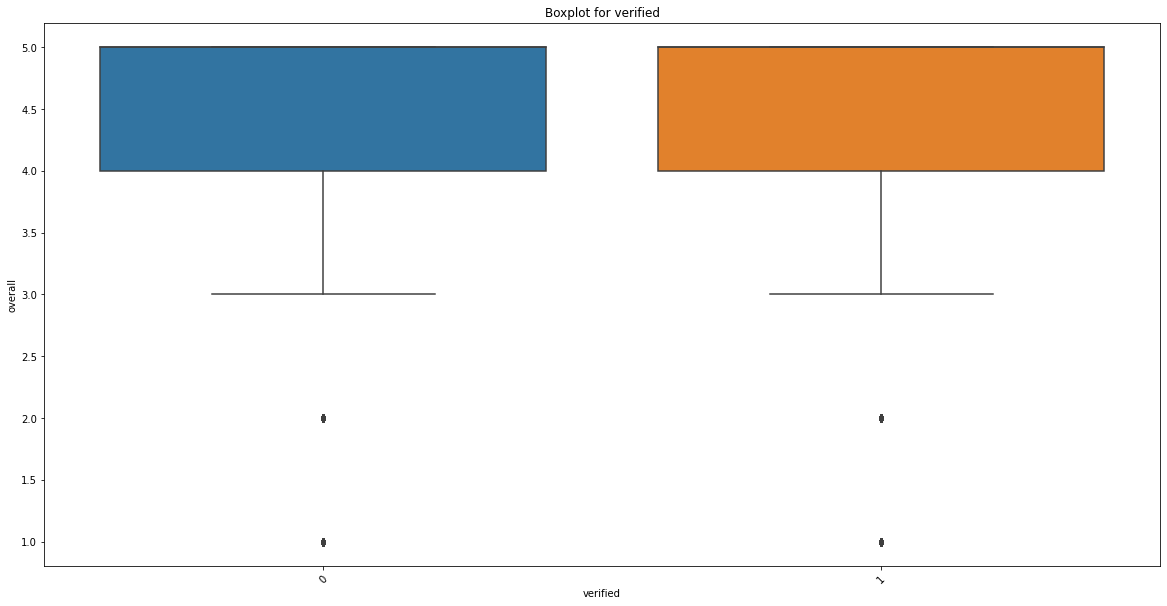

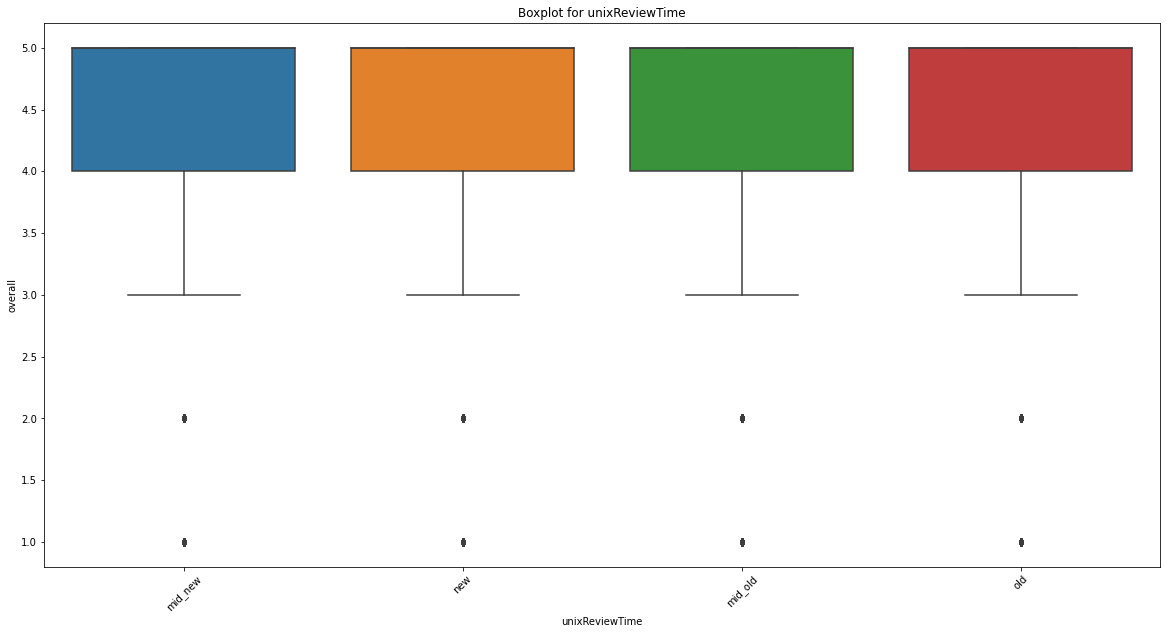

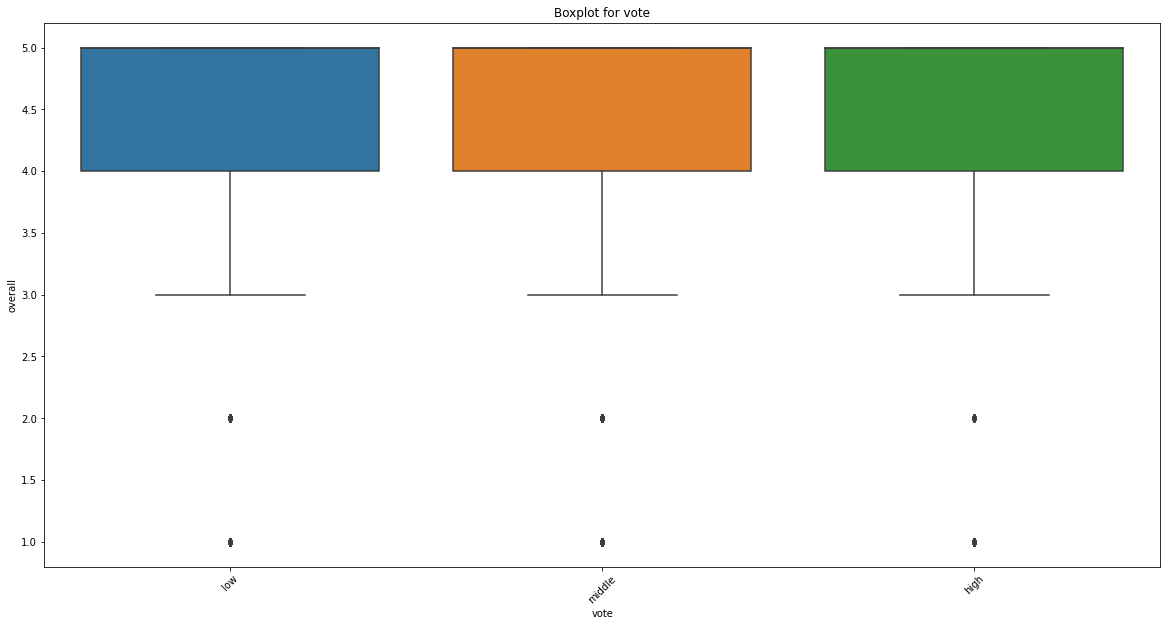

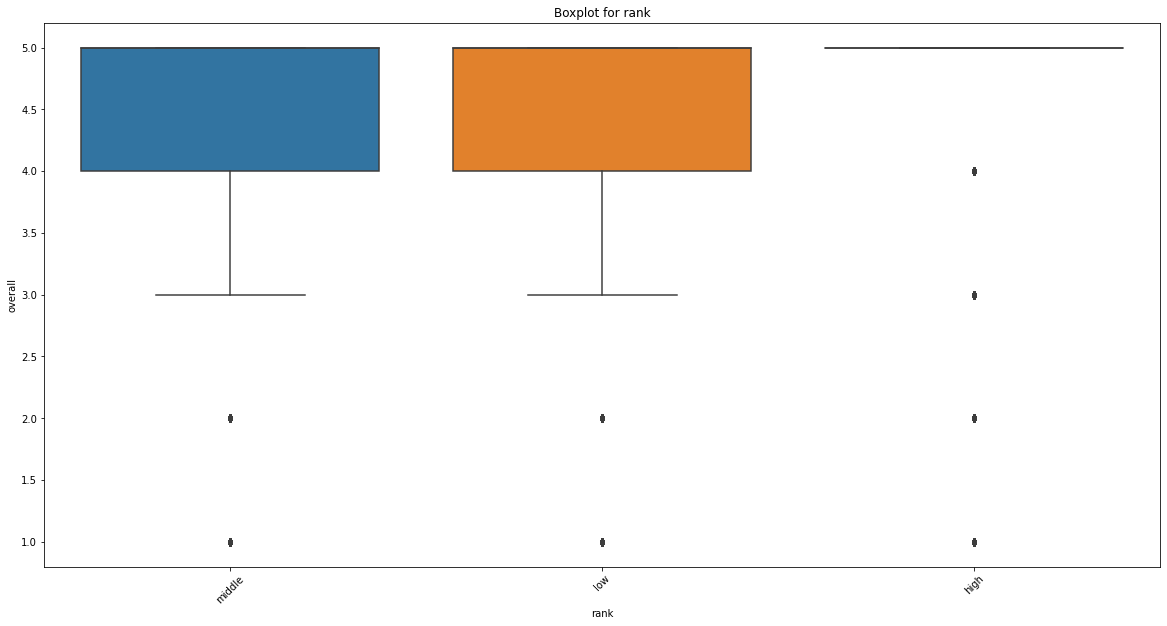

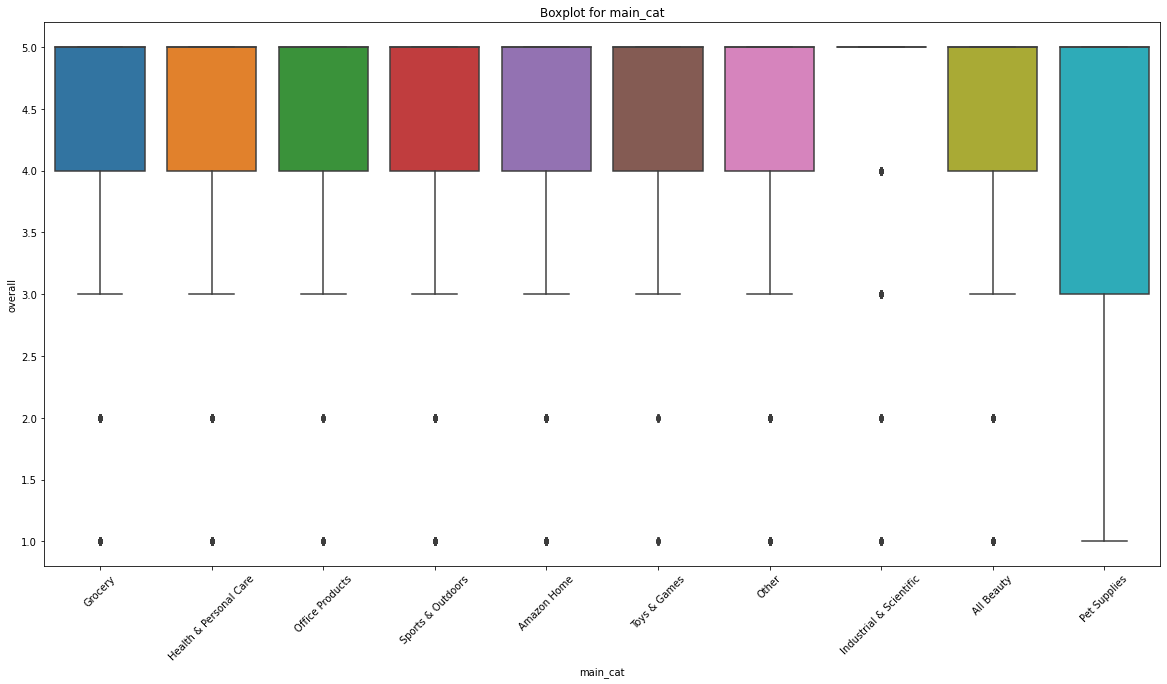

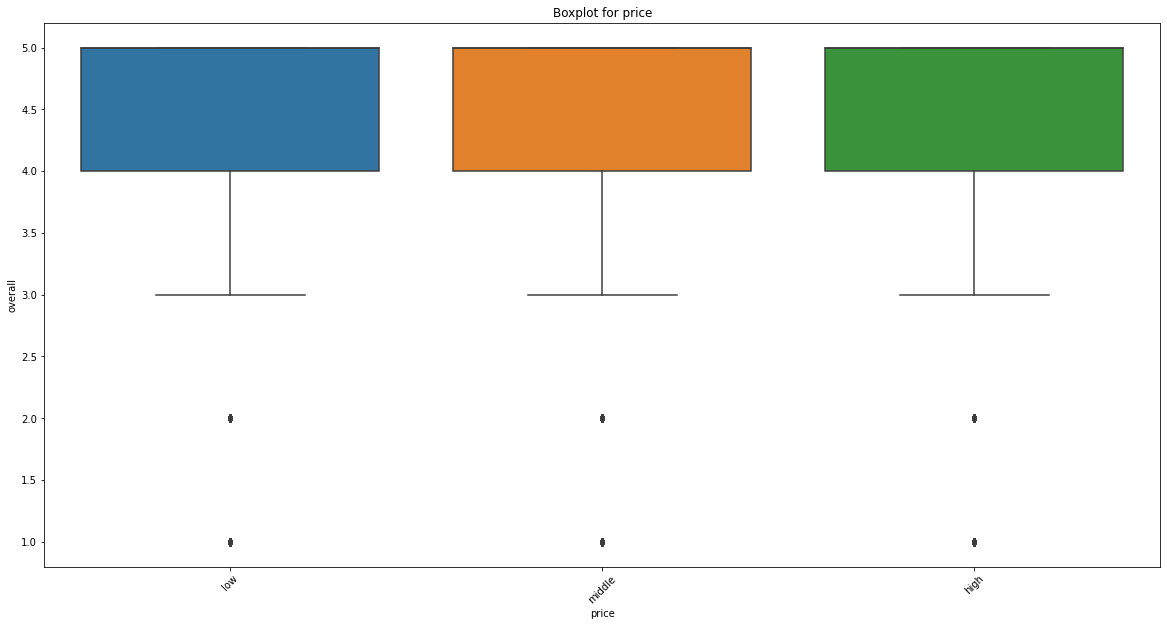

In [81]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_boxplot(col)

У всех признаков имеются выбросы. 

**Значимость категориальных переменных**

In [82]:
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'overall'], 
                        data.loc[data.loc[:, column] == comb[1], 'overall']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [83]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки unixReviewTime
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки rank
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки price


Все параметры серьезно отличаются. Удалим **overall**

In [84]:
data = data.drop('overall', axis=1)

**Подготовка данных к машинному обучению**

Создадим dummy переменные

In [85]:
for column in ['unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    dummies = pd.get_dummies(data[column], prefix = data[column].name)
    # Удаляем исходный столбец и добавляем dummies
    data = data.drop(data[column].name, axis=1).join(dummies)

**Создание модели**

In [86]:
train_data, test_data = train_test_split(data,random_state=32, shuffle=True)


In [87]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [88]:
NUM_THREADS = 2 #число потоков
NUM_COMPONENTS = 80 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [89]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)


In [90]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)


0.7420062895514032

In [91]:
preds = model.predict(test.userid.values,
                      test.itemid.values)


In [92]:
preds.min(), preds.max()

(-31.935016632080078, 30.87961196899414)

In [93]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()


In [94]:
normalized_preds.min(), normalized_preds.max()


(0.0, 1.0)

In [95]:
submission['rating']= normalized_preds

In [96]:
submission.to_csv('submission_log.csv', index=False)

**Улучшаем модель**

In [97]:
# Достаём эбмеддинги

item_biases, item_embeddings = model.get_item_representations()


Мы получили эмбеддинги — что делать с ними дальше? Эмбеддинги нам нужны, чтобы давать предсказание к каждому товару, а точнее искать наиболее похожие. Но как быстро найти среди более 40 000 товаров наиболее похожий? На помощь нам приходит метод ближайших соседей, approximate k-nn, который реализован в библиотеке nmslib.

Вместо того, чтобы перебирать все вершины, мы можем очень быстро обходить граф.

In [98]:
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [99]:
#Вспомогательная функция для поиска по графу
def nearest_item_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

Попробуем написать рекомендации к какому-нибудь товару, возьмем случайный itemid

In [100]:
i = data.itemid.sample()

ищем похожие товары

In [101]:
nbm = nearest_item_nms(i,nms_idx)[0]

Выводим похожие товары

In [102]:
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
data = pd.merge(train, meta, on='asin')
data['title'][data.itemid.isin(nbm)]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


25038     Planters Flavored Peanuts, Sea Salt & Vinegar,...
25039     Planters Flavored Peanuts, Sea Salt & Vinegar,...
25040     Planters Flavored Peanuts, Sea Salt & Vinegar,...
25041     Planters Flavored Peanuts, Sea Salt & Vinegar,...
25042     Planters Flavored Peanuts, Sea Salt & Vinegar,...
                                ...                        
850070            Amoretti Premium Syrup, Peach, 25.4 Ounce
857824    Frank's RedHot Stingin Honey Garlic Hot Sauce,...
857825    Frank's RedHot Stingin Honey Garlic Hot Sauce,...
857826    Frank's RedHot Stingin Honey Garlic Hot Sauce,...
857827    Frank's RedHot Stingin Honey Garlic Hot Sauce,...
Name: title, Length: 7089, dtype: object

In [106]:
with open('/kaggle/working/item_embeddings.pickle', 'wb') as file:
   pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)